In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## **MAIN CODE to get the rating and number of votes for each album**

In [23]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

253790

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import ftfy   # to fix names with unusual characters

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

count = 0
scrapped = 0

start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+2000):
    count+=1

    if album_id in df_ratings_scrapped['album_id'].values:
        print(f'{scrapped}/{count} - id {album_id}: album already scrapped')
        continue  # Skip this album, I already have it

    url = f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'
    response = requests.get(f"{url}")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        artist_name = ftfy.fix_text(artist)
        album = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
        album_name = ftfy.fix_text(album)     # fix the name 
    except IndexError:
        print(f"{scrapped}/{count} - id {album_id}: error")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"{scrapped}/{count} - id {album_id}: No artist found")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'{scrapped}/{count} - id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list

        scrapped+=1
    else:
        print(f"{scrapped}/{count} - id {album_id}: No valid ratings found.")

0/1 - id 252792: Half Gramme of Soma - Groove is Black
1/2 - id 252793: Desert Afternoon - Desert Afternoon
2/3 - id 252794: Guillemet - Demo
3/4 - id 252795: Guillemet - Guillemet
4/5 - id 252796: La Letra Pequeña - Demo 2011
5/6 - id 252797: La Letra Pequeña - Demo 2
6/7 - id 252798: HEXOLYTH - Until We're Gone
7/8 - id 252799: No artist found
7/9 - id 252800: No artist found
7/10 - id 252801: Valor (GR) - The Nameless One
7/10 - id 252801: No valid ratings found.
7/11 - id 252802: Taeko Onuki - Grey Skies
8/12 - id 252803: American High - Bones in the  Attic, Flowers in the Basement
9/13 - id 252804: No artist found
9/14 - id 252805: Manic - Manic
9/14 - id 252805: No valid ratings found.
9/15 - id 252806: Finnish Radio Symphony Orchestra - Tüür: Peregrinus ecstaticus; Noēsis; Le poids ...
10/16 - id 252807: CRWN - Tommy Gun (Instrumental)
11/17 - id 252808: B.o.B - Ether
12/18 - id 252809: Valor (GR) - Destiny's Path
12/18 - id 252809: No valid ratings found.
12/19 - id 252810: Val

In [142]:
(47*60+48)/5000

0.5736

## **Saving the data**

In [207]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 699
artists: 699
albums: 699
avg_rating: 699
number_of_votes: 699


In [208]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

699 releases
576 different artists


In [209]:
data

,album_id,artist,album,rating,votes
0,252792,Half Gramme of Soma,Groove is Black,3.38,5
1,252793,Desert Afternoon,Desert Afternoon,2.75,2
2,252794,Guillemet,Demo,2.75,2
3,252795,Guillemet,Guillemet,3.50,2
4,252796,La Letra Pequeña,Demo 2011,2.50,1
...,...,...,...,...,...
694,253786,SZA,Ctrl,3.76,406
695,253787,Nick Reinhart,satan's power II,2.00,1
696,253788,Nick Reinhart,Scary Sounds II,2.50,1
697,253789,Nick Reinhart,Satan's Power III,1.50,1


In [210]:
print(f'I could webscrap {round(scrapped / count*100, 2)}% of the albums\n{scrapped} of {count} total albums')

I could webscrap 69.97% of the albums
699 of 999 total albums


In [211]:
print(f'{data[data['votes']<10].shape[0]} albums with < 10 votes, meaning {round((data[data['votes']<10].shape[0] / data.shape[0])*100,2)}% of the albums \n{data[data['votes']>10].shape[0]} of {data.shape[0]} actual valid albums')

595 albums with < 10 votes, meaning 85.12% of the albums 
99 of 699 actual valid albums


In [212]:
# most voted albums
data.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
92,252917,Vince Staples,Big Fish Theory,3.75,796
448,253451,Leprous,Malina,3.92,677
694,253786,SZA,Ctrl,3.76,406
284,253198,Silverstein,Dead Reflection,3.58,316
218,253122,Grizzly Bear,Painted Ruins,3.73,295
628,253686,Death Grips,Steroids (Crouching Tiger Hidden Gabber Megamix),3.73,287
533,253565,Neck Deep,The Peace And The Panic,3.24,264
38,252843,Mogwai,Every Country's Sun,3.49,260
587,253640,Arcane Roots,Melancholia Hymns,3.91,220
241,253148,blink-182,California (Deluxe Edition),2.85,145


In [213]:
# top rated albums 
data[data['votes']>100].sort_values('rating', ascending=False).head(10)

,album_id,artist,album,rating,votes
448,253451,Leprous,Malina,3.92,677
587,253640,Arcane Roots,Melancholia Hymns,3.91,220
660,253739,City of Caterpillar,Driving Spain Up A Wall,3.88,135
247,253154,Richard Dawson,Peasant,3.79,108
694,253786,SZA,Ctrl,3.76,406
92,252917,Vince Staples,Big Fish Theory,3.75,796
218,253122,Grizzly Bear,Painted Ruins,3.73,295
628,253686,Death Grips,Steroids (Crouching Tiger Hidden Gabber Megamix),3.73,287
224,253128,Integrity,"Howling, For the Nightmare Shall Consume",3.66,119
284,253198,Silverstein,Dead Reflection,3.58,316


In [214]:
# plt.figure(figsize=(6,9))
# sns.countplot(data=data, y='votes')

## Concat with the df of the ratings previously scrapped

In [7]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
df_ratings_scrapped.shape

(157482, 5)

In [8]:
df_ratings_less_30_2 = pd.read_csv('Datasets/df_ratings_less_30_2.csv')
df_ratings_less_30_2.shape

(95309, 5)

In [9]:
df_ratings = pd.concat([df_ratings_scrapped, df_ratings_less_30_2])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(252791, 5)

In [10]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

252791 albums
70192 different artists


In [11]:
min_votes = 20

print(f'{round((df_ratings[df_ratings['votes']<min_votes].shape[0] / df_ratings.shape[0])*100,2)}% of the albums have less than {min_votes} votes')

80.79% of the albums have less than 20 votes


## **Exporting to csv (and importing in case needed)**

In [22]:
df_ratings_scrapped.to_csv('Datasets/df_ratings.csv', index=False)

In [ ]:
# in case I have to import it again
# df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

In [221]:
df_ratings['album'].isna().sum()

42

In [220]:
df_ratings[df_ratings['album'].isna()]

,album_id,artist,album,rating,votes
12252,15674,Duke Ellington,NaN,4.27,15
13989,17721,Manic Hispanic,NaN,3.50,1
17937,22490,Instruction,NaN,0.00,1
21804,27049,Coconut Pete,NaN,5.00,1
26172,32154,Dreaming In Oceans,NaN,2.88,13
26550,32591,The Hollies,NaN,4.17,3
29268,35979,Meshuggah,NaN,3.78,314
36014,44011,Lymbyc Systym,NaN,2.00,1
36265,44314,Bushido,NaN,3.44,17
45323,55414,Some Pedestrians,NaN,2.75,2


In [ ]:
# df_ratings.iloc[15417]['album']

'None'

In [ ]:
# replace the null values for the actual name of the album
# df_ratings['album'] = np.where(df_ratings['album_id']==35979, 'None' , df_ratings['album'])
# df_ratings.iloc[15417]['album']

'None'

## **Statistics**

**Top rated albums**

In [152]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>100').head(5)

,album_id,artist,album,rating,votes
19053,23820,Sigur Ros,Heima (DVD),4.65,388
414,531,Pink Floyd,Wish You Were Here,4.63,7065
33320,40844,Pink Floyd,Live At Pompeii,4.62,363
1897,2532,Deep Purple,Made In Japan,4.61,513
9210,11956,The Who,Live at Leeds (Deluxe Edition),4.59,184


**Most voted albums**

In [153]:
df_ratings.sort_values('votes', ascending=False).head(5)

,album_id,artist,album,rating,votes
1249,1484,Radiohead,OK Computer,4.54,9186
59,116,Metallica,Master Of Puppets,4.45,8950
69,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
148,222,Metallica,Ride The Lightning,4.42,8013
152,226,Radiohead,Kid A,4.43,7685


In [154]:
df_ratings.artist.value_counts().head(10)

artist
Bull Of Heaven             367
Buckethead                 285
Soundtrack (Film)          248
Various Artists            247
John Zorn                  102
Psychic TV                  92
Soundtrack (Video Game)     84
Miles Davis                 82
Frank Zappa                 81
Johnny Cash                 80
Name: count, dtype: int64

In [156]:
df_ratings[df_ratings['artist']=='King Gizzard and The Lizard Wizard'].sort_values('rating', ascending=False)

,album_id,artist,album,rating,votes
131603,217111,King Gizzard and The Lizard Wizard,Nonagon Infinity,4.05,761
103671,176117,King Gizzard and The Lizard Wizard,I'm In Your Mind Fuzz,4.02,456
145405,236071,King Gizzard and The Lizard Wizard,Flying Microtonal Banana,3.81,634
86940,143936,King Gizzard and The Lizard Wizard,Float Along. Fill Your Lungs,3.80,241
116249,194559,King Gizzard and The Lizard Wizard,Quarters,3.70,259
126159,208940,King Gizzard and The Lizard Wizard,Paper Mache Dream Balloon,3.65,293
86093,129313,King Gizzard and The Lizard Wizard,Willoughby's Beach,3.30,77
96852,166664,King Gizzard and The Lizard Wizard,Oddments,3.28,206
86942,143938,King Gizzard and The Lizard Wizard,12 Bar Bruise,3.25,199
86941,143937,King Gizzard and The Lizard Wizard,Eyes Like The Sky,2.96,162


In [79]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
2405,3667,Various Artists,Music as a Weapon II,3.03,85
8166,15291,Various Artists,A Christmas Gift For You,3.82,50
11700,23878,Various Artists,No New York,4.11,68
20808,65942,Various Artists,Whom The Moon A Nightsong Sings,3.87,32
28227,155742,Various Artists,Let No One Judge You: Early Recordings from Iran,3.25,2
...,...,...,...,...,...
131718,96984,Various Artists,Punk Goes Pop 4,2.15,17
133981,100142,Various Artists,Elect-Lo-Nica Compilation,1.50,1
135115,101704,Various Artists,New Orleans -The Original Sound of Funk 1960-1975,3.00,1
136753,154131,Various Artists,"100 Moons: Hindustani Vocal Art, 1930-55",3.50,2


In [81]:
df_ratings[df_ratings['artist']=='Soundtrack (Film)']

,album_id,artist,album,rating,votes
5954,10169,Soundtrack (Film),South Park (Original Soundtrack),3.93,64
6021,10302,Soundtrack (Film),Pulp Fiction,3.88,85
6204,10653,Soundtrack (Film),Team America: World Police,3.97,38
6541,11286,Soundtrack (Film),The Crow,3.91,44
9511,18273,Soundtrack (Film),Garden State,3.75,46
...,...,...,...,...,...
132281,97757,Soundtrack (Film),The Hunger Games,3.17,21
133099,98837,Soundtrack (Film),Collateral,2.88,4
135567,102385,Soundtrack (Film),Ma 6-T Va Cracker,4.00,1
136583,103895,Soundtrack (Film),Fight Club,3.93,14


In [89]:
df_ratings['votes'].value_counts().head(15)

votes
1     28632
2     15339
3     10239
4      7320
5      5863
6      4645
7      3920
8      3272
9      2806
10     2442
11     2251
12     2035
13     1750
14     1555
15     1406
Name: count, dtype: int64

<Axes: xlabel='votes', ylabel='Count'>

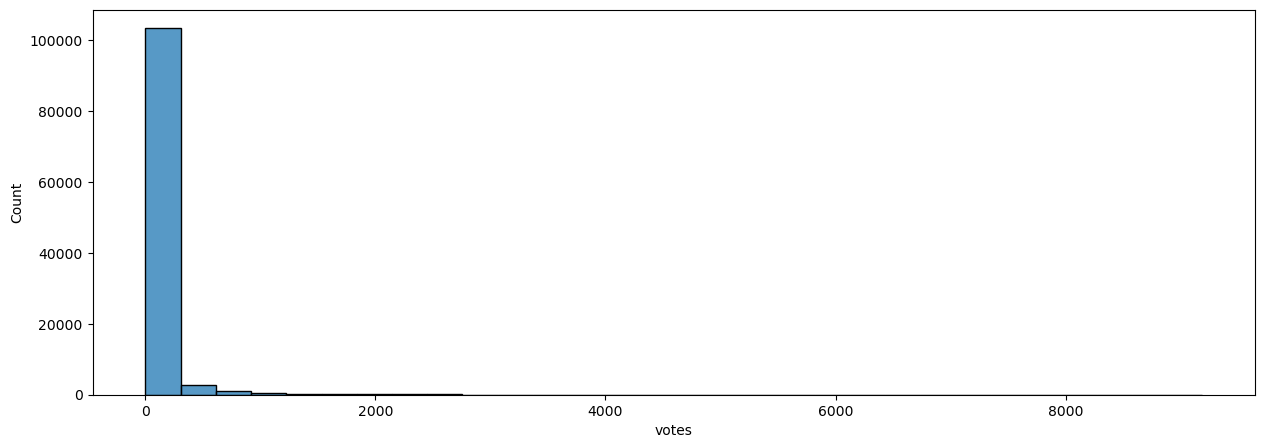

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_ratings[df_ratings['votes']>1], x='votes', bins=30)

In [87]:
df_ratings.shape

(137202, 5)